## PREPROCESSING

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


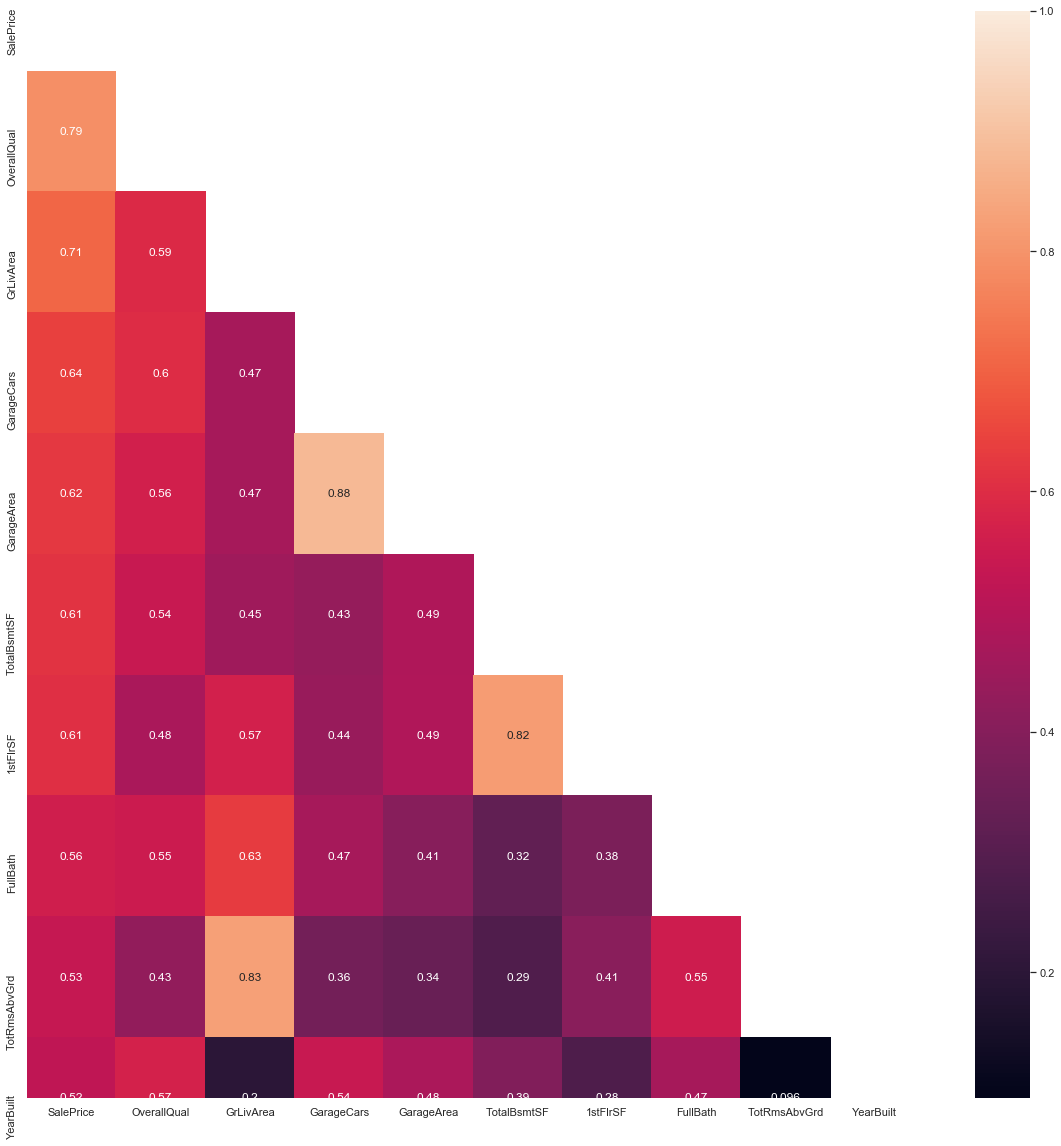

In [17]:
#saleprice correlation matrix
corr=train.corr()
k = 10
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)

mask = np.zeros_like(cm)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20,20))
sns.set(font_scale=1)
sns.set_style("whitegrid")
hm = sns.heatmap(cm, mask=mask, annot=True, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

C:\Users\bigdata\DS\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


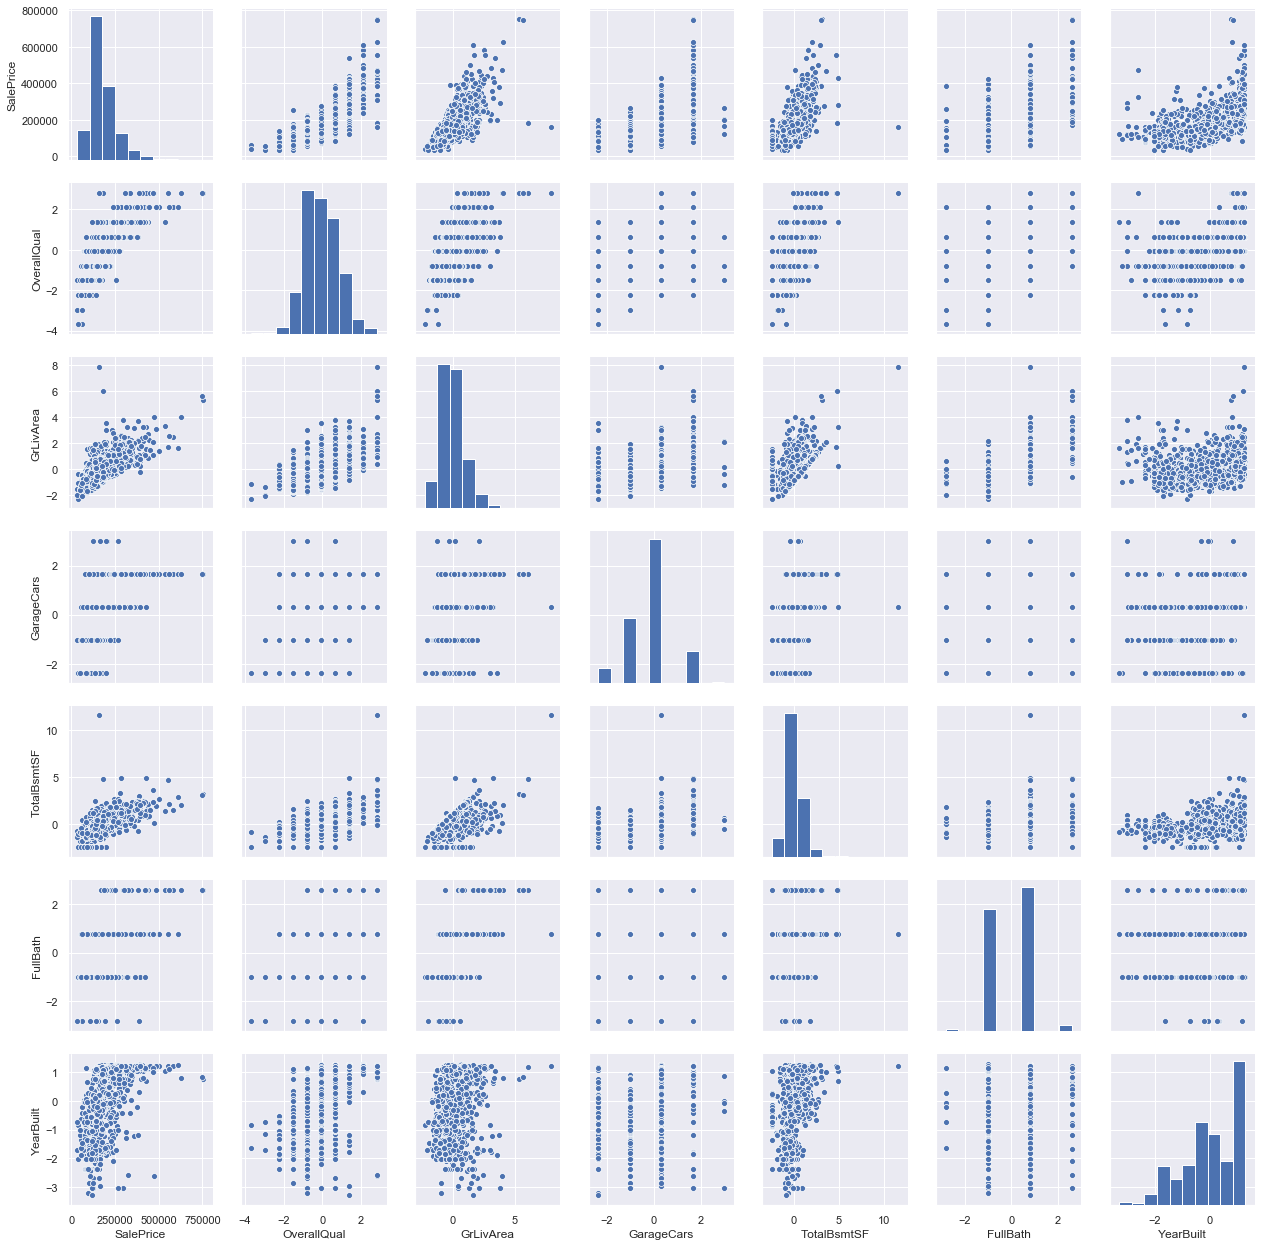

In [757]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

No handles with labels found to put in legend.


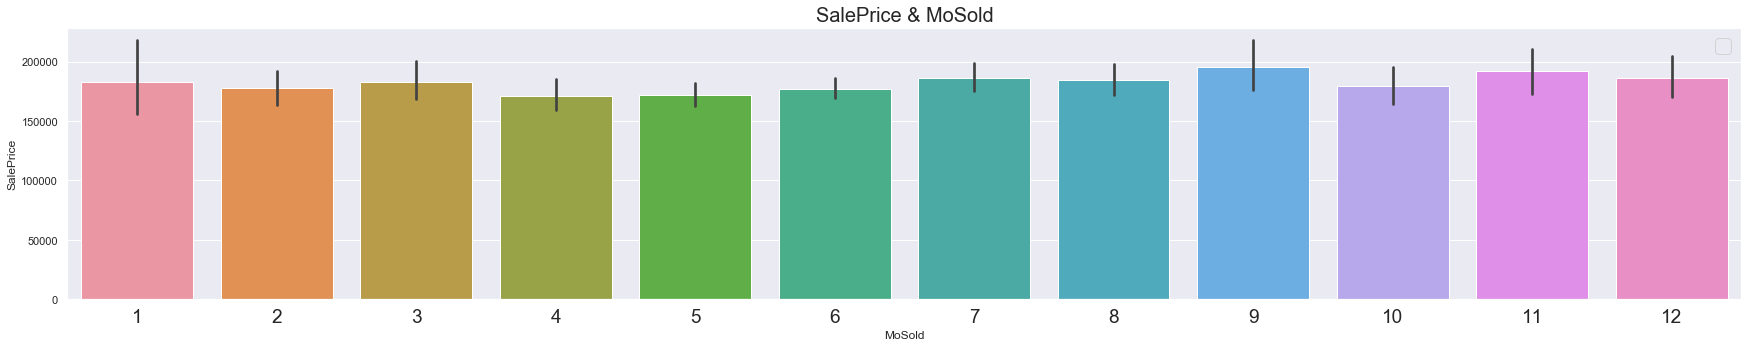

In [817]:
plt.figure(figsize=(30,5))
chart=sns.set(palette="pastel")
sns.barplot(train["MoSold"], train["SalePrice"])
plt.xticks(rotation='0', fontsize=19)
plt.legend(fontsize=20)
plt.title("SalePrice & MoSold",fontsize=20)
plt.show()

In [13]:
print(test.isnull().sum().sort_values(ascending=False)[:40])

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageQual        78
GarageYrBlt       78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
BsmtUnfSF          1
TotalBsmtSF        1
SaleType           1
Exterior1st        1
KitchenQual        1
GarageArea         1
GarageCars         1
HouseStyle         0
LandSlope          0
MSSubClass         0
LotArea            0
Street             0
LotShape           0
LandContour        0
dtype: int64


In [66]:
def handle_missing(features):
    # the data description states that NA refers to typical ('Typ') values
    features['Functional'] = features['Functional'].fillna('None')
    # Replace the missing values in each of the columns below with their mode
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # the data description stats that NA refers to "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # NaN values for these categorical basement features, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

In [67]:
train=handle_missing(train)
test=handle_missing(test)

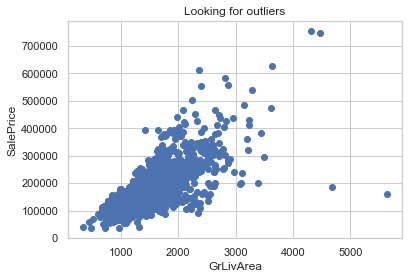

In [68]:
# Looking for outliers
plt.scatter(train.GrLivArea, train.SalePrice)
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

train = train[train.GrLivArea < 4000]

In [69]:
#Feature_selection
id_test=test["Id"]
id_train=train["Id"]

def creating_feature(all_features):
    all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
    all_features['YearsSinceBuilt'] = all_features['YrSold'] - all_features['YearBuilt']
    all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']
    all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
    all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                                   all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
    all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                                  all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                                  all_features['WoodDeckSF'])
    all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    all_features = all_features.drop(['Utilities', 'Street', 'PoolQC','PoolArea','Id'], axis=1)
    all_features=all_features.drop(['YearRemodAdd','OverallQual','OverallCond','TotalBsmtSF','1stFlrSF','2ndFlrSF',
                                   'OpenPorchSF','3SsnPorch','EnclosedPorch','ScreenPorch','WoodDeckSF',
                                   'Fireplaces'], axis=1)
    return all_features


In [70]:
train=creating_feature(train)
test=creating_feature(test)

In [60]:
print(train.columns)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'MiscFeature',
       'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice',
       'YearsSinceRemodel', 'YearsS

In [71]:
#Log transform skew data

from scipy.stats import skew
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

def log_transform(data):
    #log transform skewed numeric features:
    numeric_feats = data.dtypes[data.dtypes != "object"].index

    skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index
    print(skewed_feats)
    data[skewed_feats] = np.log1p(data[skewed_feats])
    return data

train=log_transform(train)
test=log_transform(test)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF2',
       'BsmtUnfSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath',
       'KitchenAbvGr', 'MiscVal', 'Total_porch_sf', 'haspool'],
      dtype='object')
Index(['MSSubClass', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'MiscVal', 'TotalSF', 'Total_porch_sf',
       'haspool'],
      dtype='object')


In [89]:
def Dummify(data):
    #Convert to categorical
    categorical_features=data.columns[data.dtypes == "object"].tolist()
    categorical_features.append("MoSold")
    for features in categorical_features:
        data[features]=pd.Categorical(data[features])

    #Dummify
    db_dummies = pd.get_dummies(data[categorical_features], drop_first=True)
    df = pd.concat([db_dummies,data.drop(categorical_features, axis=1)], axis=1)
    return df

train=Dummify(train)
test=Dummify(test)


In [92]:
print("Après dummification des grandeures catégorielles, le nombre de features s'élève à :",len(train.columns))

Après dummification des grandeures catégorielles, le nombre de features s'élève à : 262


In [778]:
#Standardisation
from sklearn.preprocessing import StandardScaler
numeric=train.columns[train.dtypes != "object"].tolist()
numeric.pop()
numeric.pop(0)

scaler=StandardScaler().fit(train[numeric])
train[numeric] = scaler.transform(train[numeric])
test[numeric]= scaler.transform(test[numeric])

In [94]:
train.to_csv("train2.csv")
test.to_csv("test2.csv")